In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore') #don't want warnings in my notebook output on github

csv_file = 'data\document_type_data.csv'
df = pd.read_csv(csv_file, index_col=[0])
df.text = df.text.map(lambda x: " ".join(eval(x)))
df

,ocr,text,label,file_name
0,"{'pageImages': [{'__typename': 'Image', 'width...","Chaikin, Karen n O' o From: Sent: To: ...",email,2085136614c.pdf
1,"{'pageImages': [{'__typename': 'Image', 'width...","> Jenny, After speaking with Elisa about...",email,2085136814a.pdf
2,"{'pageImages': [{'__typename': 'Image', 'width...",Please call with any questions. Thanks. ...,email,2085140145a.pdf
3,"{'pageImages': [{'__typename': 'Image', 'width...","2085158326 Williams, Carrie T. LBCo. will...",email,2085158326.pdf
4,"{'pageImages': [{'__typename': 'Image', 'width...",GJ □3 A nice ending to the story below...,email,2085161311b.pdf
...,...,...,...,...
95,"{'pageImages': [{'__typename': 'Image', 'width...",CURRICULUM VITAE NILANJAN ROY NAME 1st O...,resumee,50701639-1640.pdf
96,"{'pageImages': [{'__typename': 'Image', 'width...",BIOGRAPHICAL SKETCH Mark S. Ptashne Profe...,resumee,50712092-2093.pdf
97,"{'pageImages': [{'__typename': 'Image', 'width...",May. 1997 CURRICULUM VITAE Education and ...,resumee,50735851-5852.pdf
98,"{'pageImages': [{'__typename': 'Image', 'width...",I CURRICULUM VITAE * NAbE: Emil R. Unan...,resumee,80412888_80412908.pdf


## Convert string level to int.

In [2]:
labels = df.label.unique()
labels_dict = dict(zip(labels, range(len(labels))))
df["class_name"] = df.label
df["label"] = df.class_name.map(lambda x: labels_dict[x])
df[["class_name", "label"]].value_counts()

class_name  label
resumee     3        25
letter      2        25
invoice     1        25
email       0        25
dtype: int64

## Split data into train and test

### To keep things short, instead of doing a training, validation and test set split I will just do train and test. I will also **not** use any cross validation as I **would normally do**.

In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, random_state=42, stratify=df.dropna().label)
train.label.value_counts()

3    19
1    19
0    19
2    18
Name: label, dtype: int64

In [4]:
test.label.value_counts()

2    7
3    6
1    6
0    6
Name: label, dtype: int64

## FastText (using skift wrapper) only trained on this data
### Results are quite bad

In [5]:
from skift import SeriesFtClassifier
from sklearn.metrics import f1_score

sk_clf = SeriesFtClassifier()
sk_clf.fit(train.text.str, train.label)
test["prediction_fasttext"] = sk_clf.predict(test.text.str.replace("\n", " "))
print(f"F1 Score: {f1_score(test.label, test.prediction_fasttext, average='micro'):.2f}")

F1 Score: 0.28


## TF-IDF fitted on all data, transform test+train data to vectors and train SVM
### Now these are some better results using the simplest tools. This can probably linked to earlier analysis that there are some very predicitve terms in certain classes such as 'invoice' occuring in 84% of invoices and in no other documents.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
import numpy as np

def tfidf_fit_transform(text_field: str) -> None:
    tf_idf = TfidfVectorizer()
    tf_idf.fit(df[text_field])
    X_train = tf_idf.transform(train[text_field])
    X_test = tf_idf.transform(test[text_field])
    return X_train, X_test

def get_svm_predictions(X_train, Y_train, X_test):
    clf = SVC(probability=True, kernel='rbf', random_state=42)
    clf.fit(X_train, Y_train)

    # predict and evaluate predictions
    predictions = clf.predict_proba(X_test)
    return predictions


def print_scores(Y_test, predictions):
    print(f"ROC-AUC: {roc_auc_score(Y_test, predictions, multi_class='ovr'):.2f}")
    print(f"f1: {f1_score(Y_test, np.argmax(predictions, axis=1), average='micro'):.2f}")



X_train, X_test = tfidf_fit_transform("text")
predictions = get_svm_predictions(X_train, train.label, X_test)
print_scores(test.label, predictions)


ROC-AUC: 0.98
f1: 0.88


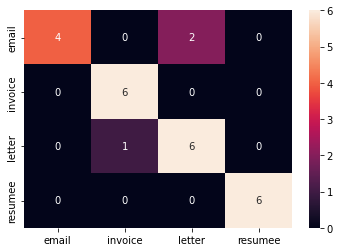

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

text_field = "text"
X_train, X_test = tfidf_fit_transform(text_field)
predictions = get_svm_predictions(X_train, train.label, X_test)
cm = confusion_matrix(test.label, np.argmax(predictions, axis=1))
x_axis_labels, y_axis_labels = df.class_name.unique(), df.class_name.unique()
f = sns.heatmap(cm, annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)

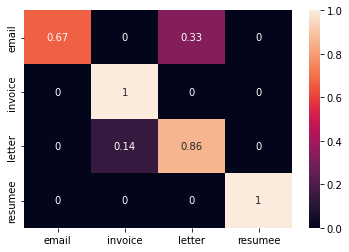

In [12]:
cm = confusion_matrix(test.label, np.argmax(predictions, axis=1), normalize='true')
x_axis_labels, y_axis_labels = df.class_name.unique(), df.class_name.unique()
f = sns.heatmap(cm, annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)

## Doc2Vec
Doc2Vec model from https://github.com/jhlau/doc2vec trained on Wikipedia

In [9]:
from gensim.models.doc2vec import Doc2Vec

model_path = f"enwiki_dbow/doc2vec.bin"

print("Load model")
model = Doc2Vec.load(model_path)

Load model


In [10]:
def get_doc2vec_vecs(text_field: str, df: pd.DataFrame) -> np.array:
    X = df[text_field].str.split()
    X = X.map(lambda x: model.infer_vector(x))
    return X

def get_train_test_vecs(text_field: str):
    X_train = get_doc2vec_vecs(text_field, train)
    X_test = get_doc2vec_vecs(text_field, test)
    return list(X_train), list(X_test)


X_train, X_test = get_train_test_vecs("text")
predictions = get_svm_predictions(X_train, train.label, X_test)
print_scores(test.label, predictions)

ROC-AUC: 0.94
f1: 0.80


## Other possibilities for embeddings

### I like the flair library from HU Berlin to get pooled word embeddings for documents or extract word embeddings from Transformer models such as the Longformer.

### Additionally I could use the image data by running it through something like VGG16 and extracting the last layer before the softmax.

### In my Master project ([github](https://github.com/pschonev/deepanomaly4docs)) I also had great success combining the image and word embeddings (see [Bakkali et al. - Visual and Textual Deep Feature Fusion for Document Image Classification](https://openaccess.thecvf.com/content_CVPRW_2020/papers/w34/Bakkali_Visual_and_Textual_Deep_Feature_Fusion_for_Document_Image_Classification_CVPRW_2020_paper.pdf)).

### I could also use the layout information from OCR - see LayoutLM.